In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from cycler import cycler
import popoff
import pop_off_functions as pof
import pop_off_plotting as pop
from Session import SessionLite
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel
from utils.utils_funcs import d_prime
from tqdm import tqdm
import svgutils.compose as sc
import IPython.display as ip

/home/loidolt/RowlandEtAl/popping-off/popoff/popoff/loadpaths.py
/home/loidolt/RowlandEtAl/Vape


In [347]:
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from scipy.optimize import curve_fit

In [56]:
pas = PoolAcrossSessions(remove_targets=False, subsample_sessions=False,
                         remove_toosoon=True, pre_start=-8)
    

long post time
long post time
long post time
long post time
long post time
Mouse RL070, run 29  registered no-lick hit. changed to too soon
long post time
long post time
Mouse RL117, run 29  registered no-lick hit. changed to too soon
Mouse RL117, run 29  registered no-lick hit. changed to too soon
long post time
long post time
long post time
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time


In [59]:
color_tt = {'hit': '#117733', 'miss': '#882255', 'fp': '#88CCEE', 'cr': '#DDCC77',
            'Hit': '#117733', 'Miss': '#882255', 'FP': '#88CCEE', 'CR': '#DDCC77',
            'urh': '#44AA99', 'arm': '#AA4499', 'spont': '#332288', 'prereward': '#332288', 
            'reward\nonly': '#332288', 'Reward\nonly': '#332288',
            'pre_reward': '#332288', 'Reward': '#332288', 'reward only': '#332288', 'rew. only': '#332288', 'hit&miss': 'k', 
            'fp&cr': 'k', 'photostim': sns.color_palette()[6], 'too_': 'grey',
            'hit_n1': '#b0eac9', 'hit_n2': '#5ab17f', 'hit_n3': '#117733',
            'miss_n1': '#a69098', 'miss_n2': '#985d76', 'miss_n3': '#882255',
            'hit_c1': '#b0eac9', 'hit_c2': '#5ab17f', 'hit_c3': '#117733',
            'miss_c1': '#a69098', 'miss_c2': '#985d76', 'miss_c3': '#882255'
            } 

In [60]:
pas.linear_models[0].session.n_neurons

477

In [62]:
pas.linear_models[0].flu.shape

(471, 162, 420)

In [250]:
n_session = 8
F = pas.linear_models[n_session].flu
F_rebinned = np.sum(F.reshape((F.shape[0], F.shape[1], F.shape[2]//3, 3)), axis=-1)

s1_idx = np.nonzero(pas.linear_models[n_session].session.s1_bool)[0]
hit_idx = np.nonzero(pas.linear_models[n_session].session.outcome == 'hit')[0]

In [259]:
def ML_PrePost_dFF_plot(F_rebinned, neuron_idx, trial_idx, color,
                        F_min=-1, F_max=1,
                        stim_min=int(8*10-3), stim_max=int(8*10+10*0.75), 
                        ana_min=int(8*10-7*10), ana_max=int(8*10-0.5*10),
                        earliest_ana_start=int(8*10+3*10),
                        figsize=(2,1.4)):
    
    n_bins = int(F_rebinned.shape[2])
    
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    
    pre_F_rebinned = F_rebinned[neuron_idx][trial_idx][:,:,:stim_min]
    pre_X = np.arange(0, stim_min)
    pre_F_mean = np.mean(pre_F_rebinned, axis=(0,1))
    pre_F_std = np.std(np.mean(pre_F_rebinned, axis=0), axis=0)
    
    post_F_rebinned = F_rebinned[neuron_idx][trial_idx][:,:,stim_max:]
    post_X = np.arange(stim_max, n_bins)
    post_F_mean = np.mean(post_F_rebinned, axis=(0,1))
    post_F_std = np.std(np.mean(post_F_rebinned, axis=0), axis=0)
    
    ana_X = np.arange(ana_min, ana_max)
    ana_F_mean = np.mean(F_rebinned[neuron_idx][trial_idx][:,:,ana_min:ana_max])
    
    ax.plot(pre_X, pre_F_mean, color=color)
    ax.plot(post_X, post_F_mean, color=color)
    
    ax.fill_between(pre_X, pre_F_mean - pre_F_std, pre_F_mean+pre_F_std, alpha=0.4, color=color)
    ax.fill_between(post_X, post_F_mean - post_F_std, post_F_mean+post_F_std, alpha=0.4, color=color)
    
    ax.axvspan(xmin=stim_min+1, xmax=stim_max-2, alpha=1, color=color_tt['photostim'])
    
    ax.set_ylabel(r"$\Delta F/F$")
    ax.set_xlabel("time [s]")
    
    ax.set_xticks([8*10-5*10, 8*10, 8*10+5*10])
    ax.set_xticklabels([-5, 0, +5])
    ax.set_xlim(0,n_bins)
    
    ax.set_ylim(F_min, F_max)
    
    ax.fill_between(ana_X, pre_F_mean[ana_min:ana_max]+pre_F_std[ana_min:ana_max], F_max, alpha=0.3, color='grey')
    ax.fill_between(ana_X, F_min, pre_F_mean[ana_min:ana_max]-pre_F_std[ana_min:ana_max], alpha=0.3, color='grey')
    
    ax.axhline(ana_F_mean, color='k', linestyle=':')
    
    ax.axvline(ana_min, color='k', linestyle='-')
    ax.axvline(ana_max, color='k', linestyle='-')
    
    ax.axvline(earliest_ana_start, color='k', linestyle='--')

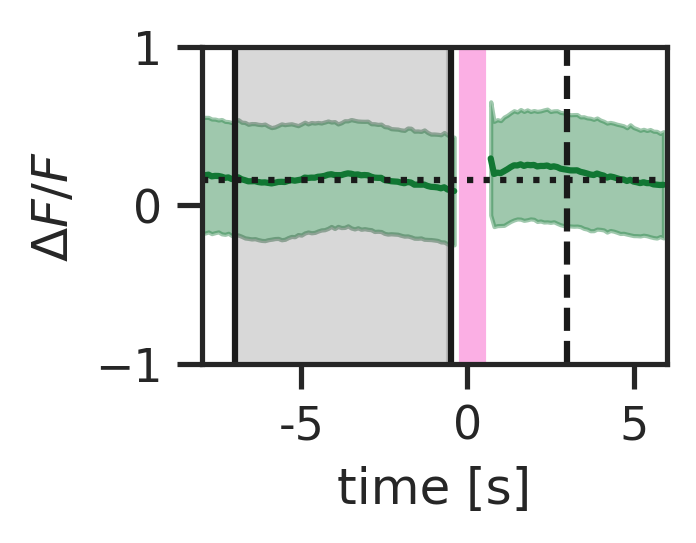

In [260]:
ML_PrePost_dFF_plot(F_rebinned, s1_idx, hit_idx, color=color_tt['hit'])


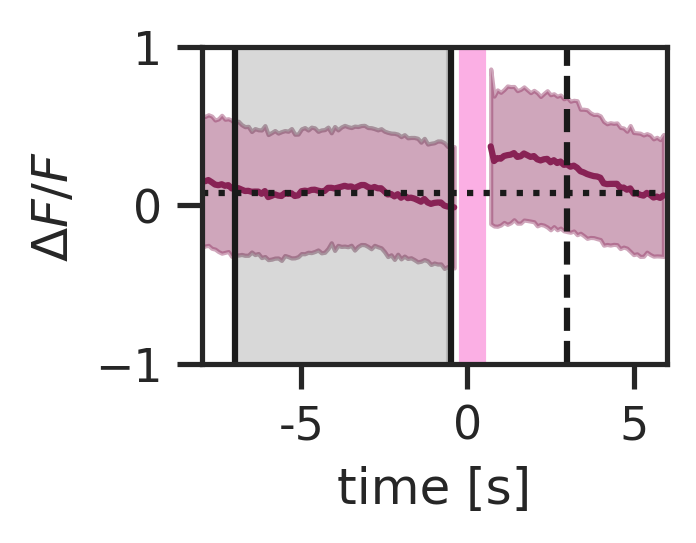

In [261]:
ML_PrePost_dFF_plot(F_rebinned, s1_idx, miss_idx, color=color_tt['miss'])


In [266]:
pre_F_rebinned = F_rebinned[s1_idx][:,:,10:75]
pre_F_concatenated = pre_F_rebinned.reshape((pre_F_rebinned.shape[0], pre_F_rebinned.shape[1]*pre_F_rebinned.shape[2]))

In [262]:
def ML_PreConcatenated_MatPlot(F):
    fig, ax = plt.subplots(figsize=(4,2.8), dpi=300)
    mats = ax.imshow(F,
                    aspect=10, cmap='gray_r', vmin=0, vmax=10)
    ax.set_xlabel("time [s]")
    ax.set_ylabel("neuron id")
    clb = fig.colorbar(mats, pad=0.1, shrink=0.325, aspect=10)
    clb.ax.set_title(r"$\Delta F/F$", fontsize=10)
    
    ax.set_xticklabels(ax.get_xticks()/10)

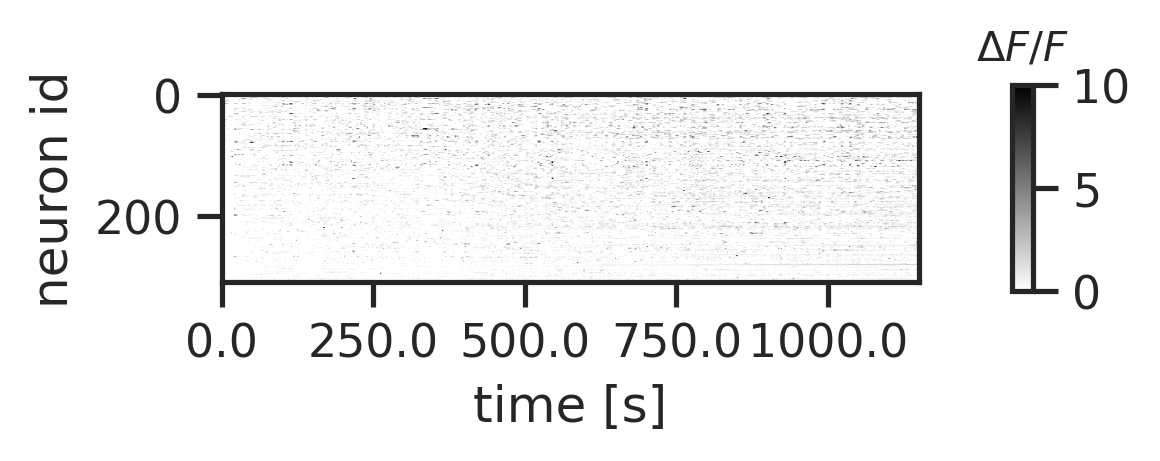

In [268]:
ML_PreConcatenated_MatPlot(pre_F_concatenated)

In [269]:
transformer = FactorAnalysis(n_components=15)

In [270]:
pre_F_factors = transformer.fit_transform(pre_F_concatenated.T)
pre_F_shared = np.dot(pre_F_factors,transformer.components_).T
pre_F_nonshared = pre_F_concatenated - pre_F_shared

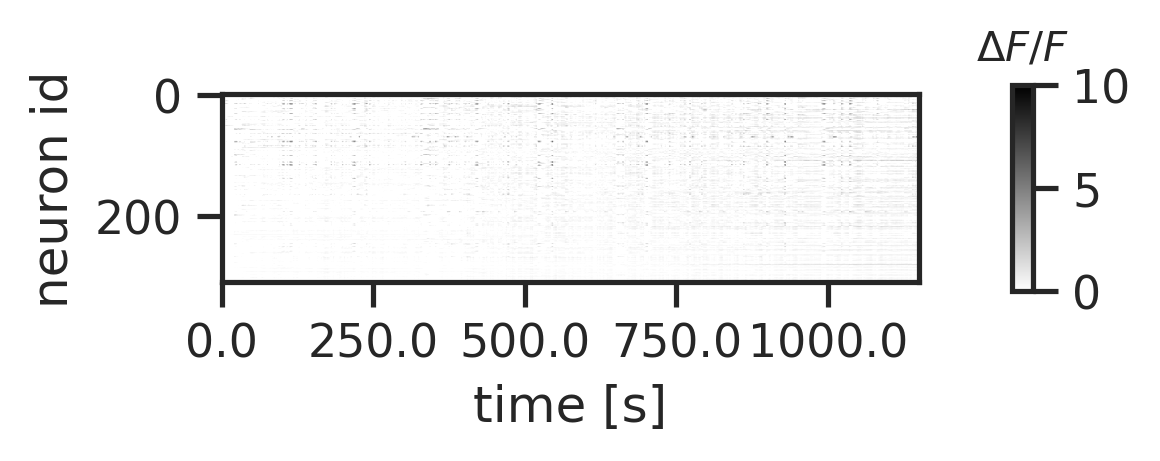

In [271]:
ML_PreConcatenated_MatPlot(pre_F_shared)

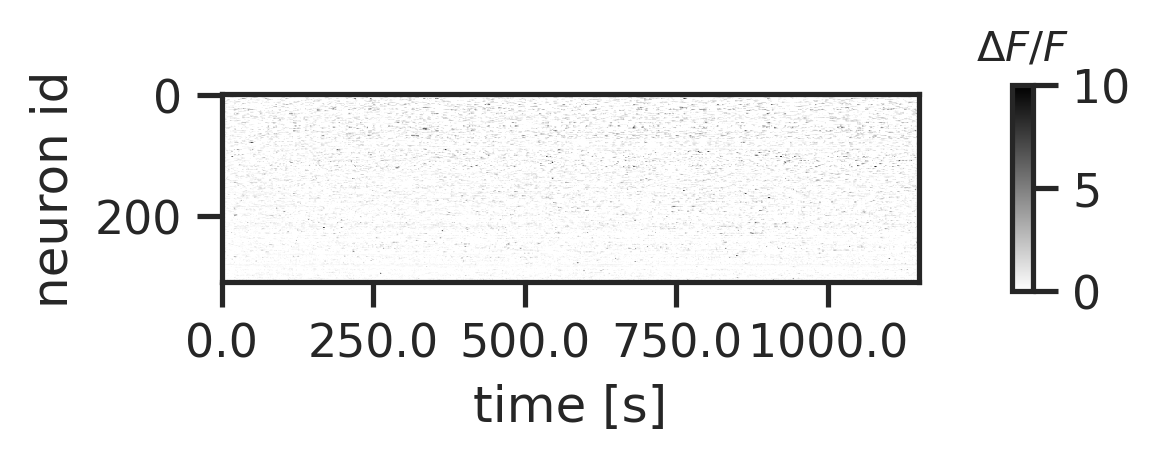

In [272]:
ML_PreConcatenated_MatPlot(pre_F_nonshared)

In [280]:
def ML_LFA_FacScan(F, factors):
    n_factors = len(factors)
    shared_var_exps = np.zeros(n_factors)
    individual_var_exps = np.zeros(n_factors)

    for i_f, factor in enumerate(factors):
        np.random.seed()
        transformer = FactorAnalysis(n_components=factor, random_state=0)
        S_transformed = transformer.fit_transform(F.T)

        n_rows = transformer.components_.shape[0]

        shared_variance = np.sum(transformer.components_**2, axis=1)

        shared_var_exps[i_f] = np.sum(shared_variance)

        individual_var_exps[i_f] = np.sum(transformer.noise_variance_)
        
    per_var_explained = shared_var_exps/(shared_var_exps+individual_var_exps)*100
    
    return per_var_explained

In [283]:
factors = [1,2,3,4,5,10,15,20,25,50,75,100,150,200,250,300]
per_var_explained = ML_LFA_FacScan(pre_F_concatenated, factors)
print(per_var_explained)

[ 8.69500084 12.17121234 16.00437445 17.43720593 19.17767638 24.43824546
 28.26106984 31.94415053 34.636905   44.90298032 53.89643787 59.48506401
 66.11725898 69.80839379 72.58498384 77.84239179]


In [285]:
def ML_Plot_FacScan(factors, per_var_explained):
    fig, ax = plt.subplots(figsize=(1.75,1.5), dpi=300)
    ax.plot(factors, per_var_explained, color='k', marker='x')
    ax.set_xlabel("number \n of factors")
    ax.set_ylabel("% var explained")

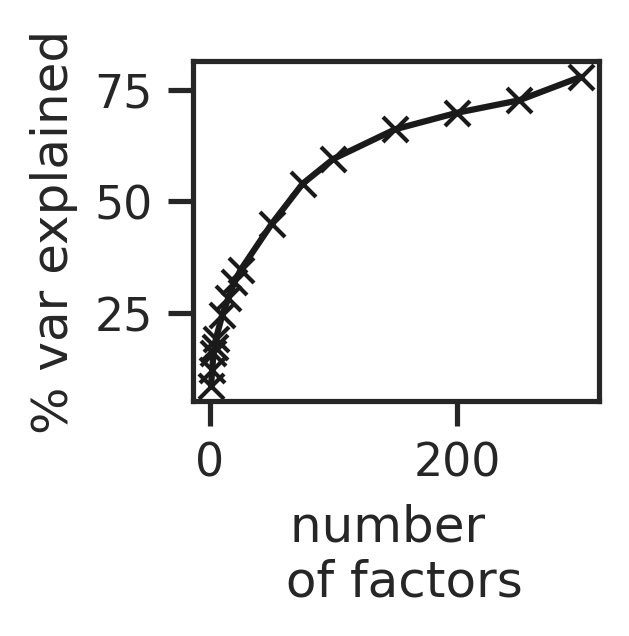

In [286]:
ML_Plot_FacScan(factors, per_var_explained)

In [306]:
def ML_CovMat_Plot(F, n_neurons=50, vmin=-0.3, vmax=0.3, TvdP_norm=True):
    
    C = np.cov(F)
    if TvdP_norm:
        a_bar = np.mean(C[np.eye(C.shape[0],dtype=bool)])
        C = C / a_bar
    
    fig,ax = plt.subplots(figsize=(2.25,2), dpi=300)
    mats = ax.imshow(C[:n_neurons,:n_neurons], cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
    cb = plt.colorbar(mats, shrink=0.5, pad=0.15, aspect=8)
    
    ax.set_xticks([0,n_neurons/2,n_neurons])
    ax.set_yticks([0,n_neurons/2,n_neurons])

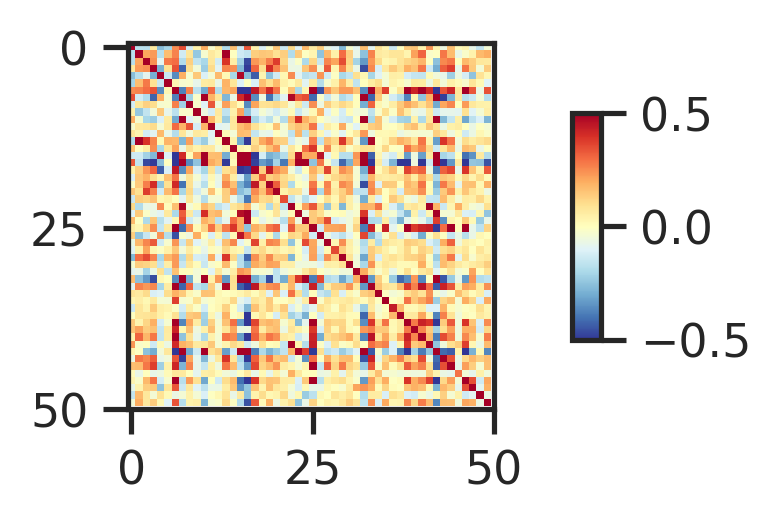

In [307]:
ML_CovMat_Plot(pre_F_concatenated, vmin=-0.5, vmax=0.5)

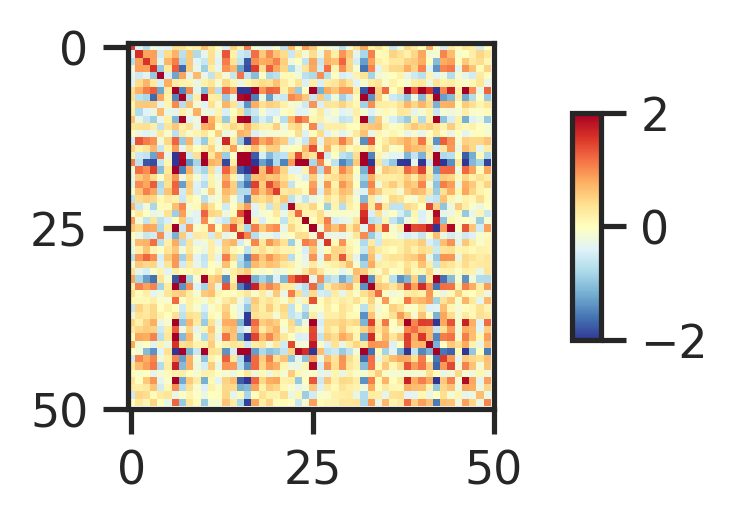

In [308]:
ML_CovMat_Plot(pre_F_shared, vmin=-2, vmax=2)

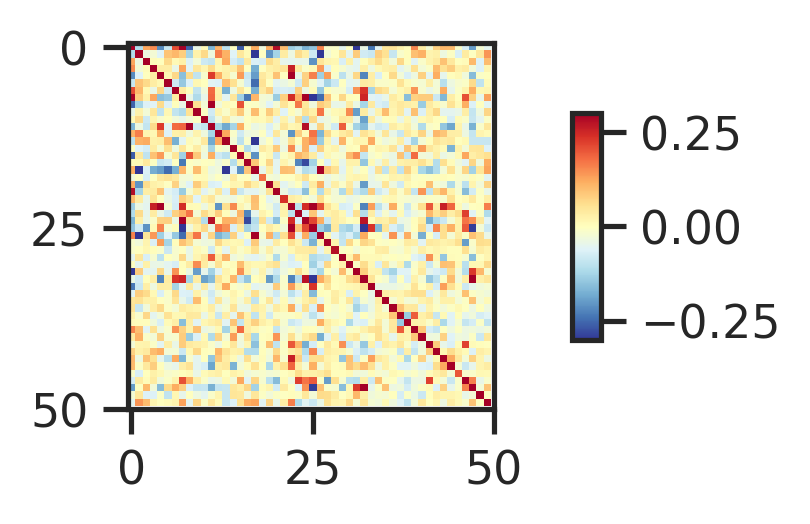

In [309]:
ML_CovMat_Plot(pre_F_nonshared, vmin=-0.3, vmax=0.3)

In [339]:
def ML_CovDist_OffDiagPlot(F, vmin=-0.3, vmax=0.3, TvdP_norm=True):
    
    C = np.cov(F)
    if TvdP_norm:
        a_bar = np.mean(C[np.eye(C.shape[0],dtype=bool)])
        C = C / a_bar
    
    off_diag = C[~np.eye(C.shape[0],dtype=bool)].ravel()
    off_X = np.linspace(np.min(off_diag), np.max(off_diag), 1000)
    off_Hist, _ = np.histogram(off_diag, off_X, density=True)
    
    dc = np.std(off_diag)
    
    fig, ax = plt.subplots(figsize=(1.8,1.6), dpi=300)
    plt.plot(off_X[:-1], off_Hist, linewidth=2, color='gold')
    
    plt.arrow(-dc, np.max(off_Hist)*1.2, 2*dc, 0, 
              color='grey', head_length=0.0175, head_width=1.5, length_includes_head = True)
    plt.arrow(dc, np.max(off_Hist)*1.2, -2*dc, 0, 
              color='grey', head_length=0.0175, head_width=1.5, length_includes_head = True)
    
    ax.text(0, np.max(off_Hist)*1.3, r"$\sigma_{CC}$", horizontalalignment='center', fontsize=8, color='grey')
    
    ax.set_xlim([vmin, vmax])
    ax.set_ylim([0,np.max(off_Hist*1.5)])
    
    ax.set_xticks([vmin,0,vmax])
    ax.set_yticks([0,np.max(off_Hist*1.5)])
    ax.set_yticklabels([0,1])
    
    plt.ylabel('density [a.u.]')
    plt.xlabel('cross-covariance \n' + r"($c_{ij, j \neq i}$)")

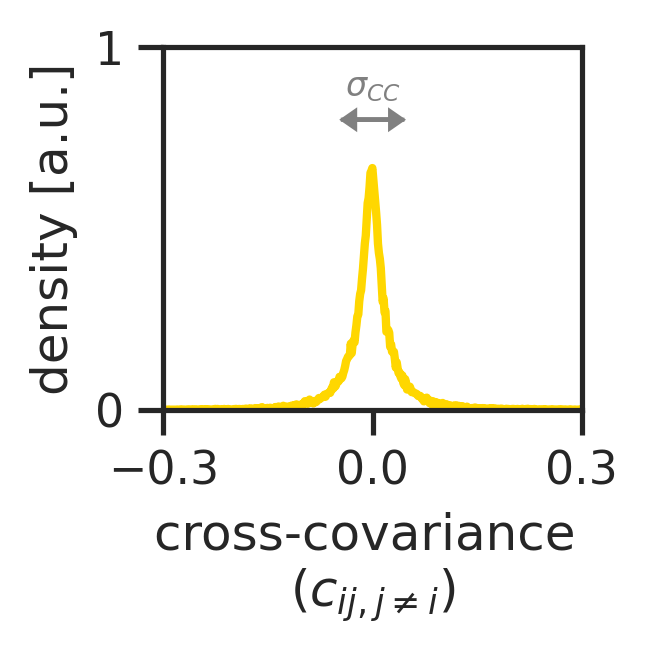

In [340]:
ML_CovDist_OffDiagPlot(pre_F_nonshared)

In [373]:
def ML_Sigma_CalcSubsampling(F, TvdP_norm=False, trial_structure=True, n_realizations=50):
    C = np.cov(F)
    if TvdP_norm:
        a_bar = np.mean(C[np.eye(C.shape[0],dtype=bool)])
        C = C / a_bar
    
    mean_cii = np.mean(C[np.eye(C.shape[0],dtype=bool)])
    
    if trial_structure:
        n_trials = np.arange(5,21)
        n_timepoints = np.arange(5*65,21*65, 65)
        std_cij_RT = np.zeros((n_trials.shape[0], n_realizations))
        
        for i_t in range(n_trials.shape[0]):
            for i_r in range(n_realizations):
                random_trials = np.random.choice(F.shape[1]//(int(6.5*10)), n_trials[i_t], replace=False)
                random_timepoints = [np.arange(i_trial*65,(i_trial+1)*(int(6.5*10))) for i_trial in random_trials]
                
                C_RT = np.cov(F[:,random_timepoints].reshape((F.shape[0], len(random_timepoints)*65)))
                if TvdP_norm:
                    a_bar = np.mean(C_RT[np.eye(C_RT.shape[0],dtype=bool)])
                    C_RT = C_RT / a_bar
                std_cij_RT[i_t,i_r] = np.std(C_RT[~np.eye(C_RT.shape[0],dtype=bool)].ravel())
                
    else:
        n_timepoints = np.arange(5*65,21*65, 65)
        std_cij_intrinsic_RT = np.zeros((n_trials.shape[0], n_realizations))
        
        for i_t in range(n_trials.shape[0]):
            for i_r in range(n_realizations):
                random_timepoints = np.random.choice(F.shape[1], n_trials[i_t], replace=False)
                
                C_RT = np.cov(F[:,random_timepoints].reshape((F.shape[0], len(random_timepoints)*65)))
                if TvdP_norm:
                    a_bar = np.mean(C_RT[np.eye(C_RT.shape[0],dtype=bool)])
                    C_RT = C_RT / a_bar
                std_cij_RT[i_t,i_r] = np.std(C_RT[~np.eye(C_RT.shape[0],dtype=bool)].ravel())
        
    inv_func = lambda T, a, dc : dc**2 + a/T
    popt, pcov = curve_fit(f=inv_func, 
                           xdata=n_timepoints, 
                           ydata=np.mean(std_cij_RT**2, axis=-1))

    # get asymptotic standard deviation of the cross-covariances
    std_cij_inf = popt[1]

    s = std_cij_inf / mean_cii
    R = np.sqrt(1-np.sqrt(1/(1+100000 * s**2)))
    return (n_timepoints, np.mean(std_cij_RT**2, axis=-1), mean_cii, std_cij_inf, popt)

In [377]:
(xdata, ydata, mean_cii, std_cij_inf, popt) = ML_Sigma_CalcSubsampling(pre_F_nonshared)

In [390]:
def ML_Sigma_PlotSubsampling(xdata, ydata, popt, xmin=False, xmax=False):
    inv_func = lambda T, a, dc : dc**2 + a/T
    
    if not xmin:
        xmin = min(xdata)
    if not xmax:
        xmax = max(xdata)
    
    xspace = np.arange(xmin, xmax)
    
    fig, ax = plt.subplots(figsize=(5/2.54,2/2.54), dpi=300)
    
    ax.plot(xdata, ydata, linestyle='', marker='.', color='grey', markersize=5)
    ax.plot(xspace, inv_func(xspace, *popt), color='gold')
    
    ax.axhline(popt[1]**2, color='gold', linestyle='--')
    
    ax.set_ylim([0, 1.2*np.max(inv_func(xspace, *popt))])
    ax.set_ylabel(r"$\sigma_{CC}^{2}(T)$")
    
    ax.set_xticklabels(ax.get_xticks()/10)
    ax.set_xlabel("time [s]")

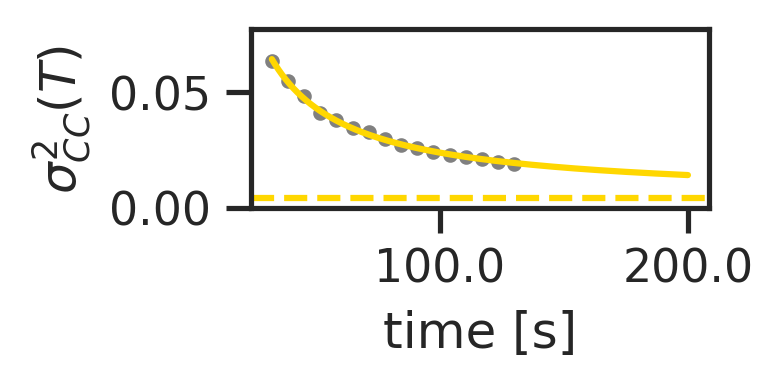

In [391]:
ML_Sigma_PlotSubsampling(xdata, ydata, popt, xmin=0, xmax=2000)